## Analysis for the story [College Students Aren’t The Only Ones Abusing Adderall](http://fivethirtyeight.com/features/college-students-arent-the-only-ones-abusing-adderall)

In [18]:
%matplotlib inline 

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = "<style>div.cell{width:100%;margin-left:1%;margin-right:auto;}.container { width:100% !important; } </style> "
    return HTML(styles)
css_styling()


# First load data

In [3]:
from pylab import *
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

#load in NSDUH data
nsduh_data = pd.read_csv('ICPSR_35509/DS0001/35509-0001-Data.tsv', sep = '\t')
#load in Niche data
niche_data = pd.read_csv('niche/SchoolPoll.csv')
#load in IPEDS data
def getIPEDSData():
    files = ['ipeds_data/CSV_7312015-162.csv', 'ipeds_data/CSV_7312015-826.csv']
    
    for i, f in enumerate(files):
        d = pd.read_csv(f)
        d.index = d.unitid 
        del d['unitid']
        if i == 0:
            all_d = d
        else:
            all_d = pd.concat([all_d, d])
    ipeds_d = {}
    for c in all_d.columns:
        new_name = c.replace(' - ', '_').replace('/', '_').replace(',', '_').replace('.', '_').replace(' ', '_')
        new_name = new_name.replace("Percent_of_total_enrollment_that_are_", '')
        ipeds_d[new_name] = dict(zip(all_d.index, all_d[c]))
    return ipeds_d
ipeds_data = getIPEDSData()
#load in Google data
google_filenames = ['ADHD_Indexed.csv','Adderall_Indexed.csv']
google_data = {}
for filename in google_filenames:
    d = pd.read_csv(os.path.join('google_data', filename))
    d.index = d.Month
    del d['Month']
    d = d.transpose()
    google_data[filename.replace('_Indexed.csv', '')] = d
    


###### "When I looked at more recent data (the 2013 National Survey on Drug Use and Health (NSDUH), an annual government survey that includes more than 55,000 Americans) the difference turned out to be closer to 1.3x, not 2x."

In [5]:
#People who respond 1 have used Adderall non-medically; no one else has.  
nsduh_data['ADDERALL'] = (nsduh_data['ADDERALL'] == 1)*1.
nsduh_data['RITALIN'] = (nsduh_data['RITMPHEN'] == 1)*1.

In [6]:

def stratifyByCat(nsduh_data, cat, drug_to_measure = 'ADDERALL', sortByVal = False):
    """
    Checked. Computes the weighted and unweighted mean values of Adderall, stratifying by 
    the levels in cat. 
    """
    levels = sorted(list(set(nsduh_data[cat].dropna())))
    print 'Category', cat
    table = []
    for l in levels:
        idxs = nsduh_data[cat] == l
        summed_weights = nsduh_data.loc[idxs]['ANALWT_C'].sum()
        mu = (nsduh_data.loc[idxs][drug_to_measure] * nsduh_data.loc[idxs]['ANALWT_C']).sum() / summed_weights
        unweighted_mu = nsduh_data.loc[idxs][drug_to_measure].mean()
        if idxs.sum() > 25:
            table.append([drug_to_measure, l, mu, unweighted_mu, idxs.sum()])
    if sortByVal:
        table = sorted(table, key = lambda x:x[2])[::-1]
    for row in table:
        print 'Mean value of %s for level %s is %2.3f; unweighted, %2.3f (%i values)' % (tuple(row))
    print 'Ratio between maximum value and minimum value', max([a[2] for a in table]) / min([a[2] for a in table])
print 'COLLENR levels:\n1: FT college students age 18 - 22; 2: other age 18 - 22; 3: other'
stratifyByCat(nsduh_data, 'COLLENR')     
stratifyByCat(nsduh_data, 'COLLENR', drug_to_measure = 'RITALIN')     



COLLENR levels:
1: FT college students age 18 - 22; 2: other age 18 - 22; 3: other
Category COLLENR
Mean value of ADDERALL for level 1 is 0.149; unweighted, 0.140 (4310 values)
Mean value of ADDERALL for level 2 is 0.115; unweighted, 0.114 (6934 values)
Mean value of ADDERALL for level 3 is 0.034; unweighted, 0.048 (43914 values)
Ratio between maximum value and minimum value 4.45754687876
Category COLLENR
Mean value of RITALIN for level 1 is 0.048; unweighted, 0.048 (4310 values)
Mean value of RITALIN for level 2 is 0.050; unweighted, 0.049 (6934 values)
Mean value of RITALIN for level 3 is 0.022; unweighted, 0.026 (43914 values)
Ratio between maximum value and minimum value 2.2055874138


###### "This is far smaller than the difference between white 18 - 22 year olds and black 18 - 22 year olds (6x, 18% vs 3%) or the difference between 18 - 22 year olds whose families do not receive food stamps and those whose do (1.6x, 14% vs 9%)."

In [7]:
young_people_idxs = nsduh_data['COLLENR'].map(lambda x:x in [1, 2])
print '\nCategories for race:\n1: white, 2: black, 3: Native Am; 4: Native HI/Other Pac Isl; 5: Asian; 6: Multiracial; 7: Hispanic'
stratifyByCat(nsduh_data.loc[young_people_idxs], 'NEWRACE2')  
stratifyByCat(nsduh_data.loc[young_people_idxs], 'NEWRACE2', drug_to_measure = 'RITALIN')

print 'Categories for food stamp: 1: respondent or family member received food stamp; 2: did not'
stratifyByCat(nsduh_data.loc[young_people_idxs], 'IRFSTAMP')    
stratifyByCat(nsduh_data.loc[young_people_idxs], 'IRFSTAMP', drug_to_measure = 'RITALIN') 
  



Categories for race:
1: white, 2: black, 3: Native Am; 4: Native HI/Other Pac Isl; 5: Asian; 6: Multiracial; 7: Hispanic
Category NEWRACE2
Mean value of ADDERALL for level 1 is 0.181; unweighted, 0.171 (6194 values)
Mean value of ADDERALL for level 2 is 0.031; unweighted, 0.034 (1602 values)
Mean value of ADDERALL for level 3 is 0.052; unweighted, 0.086 (163 values)
Mean value of ADDERALL for level 4 is 0.084; unweighted, 0.078 (64 values)
Mean value of ADDERALL for level 5 is 0.084; unweighted, 0.086 (532 values)
Mean value of ADDERALL for level 6 is 0.113; unweighted, 0.155 (491 values)
Mean value of ADDERALL for level 7 is 0.076; unweighted, 0.065 (2198 values)
Ratio between maximum value and minimum value 5.84203431864
Category NEWRACE2
Mean value of RITALIN for level 1 is 0.071; unweighted, 0.069 (6194 values)
Mean value of RITALIN for level 2 is 0.007; unweighted, 0.009 (1602 values)
Mean value of RITALIN for level 3 is 0.026; unweighted, 0.037 (163 values)
Mean value of RITALIN

### Graphs on Adderall usage by age

In [8]:
def remapAges(x):
    if x <= 3:
        return '12 - 14'
    elif x <= 6:
        return '15 - 17'
    elif x <= 10:
        return 'college age'
    elif x <= 12:
        return '23 - 25'
    elif x <= 14:
        return '26 - 34'
    return '35+'
nsduh_data['age_cat_to_plot'] = nsduh_data['AGE2'].map(remapAges)
nsduh_data['age_cat_to_plot'].loc[nsduh_data['COLLENR'] != 3] = np.nan

#This computes the values for Adderall usage stratified by age and college enrollment. 
stratifyByCat(nsduh_data, 'COLLENR')  
stratifyByCat(nsduh_data, 'age_cat_to_plot') 

#This prints out the actual data in an easy form for making graphs. Kind of hacky. 
col_vals = [0.4, 4.3, 11.5, 14.9,  14.5, 10.2, 1.1]
col_labels = ['12-14', '15-17', '18-22 (Not College)', '18-22 (In College)', '23-25', '26-34', '35+']
print 'Age\tPercent Using Adderall'
for i in range(len(col_vals)):
    print '%s\t%2.1f' % (col_labels[i], col_vals[i])

Category COLLENR
Mean value of ADDERALL for level 1 is 0.149; unweighted, 0.140 (4310 values)
Mean value of ADDERALL for level 2 is 0.115; unweighted, 0.114 (6934 values)
Mean value of ADDERALL for level 3 is 0.034; unweighted, 0.048 (43914 values)
Ratio between maximum value and minimum value 4.45754687876
Category age_cat_to_plot
Mean value of ADDERALL for level 12 - 14 is 0.004; unweighted, 0.005 (8689 values)
Mean value of ADDERALL for level 15 - 17 is 0.043; unweighted, 0.043 (9047 values)
Mean value of ADDERALL for level 23 - 25 is 0.145; unweighted, 0.140 (6896 values)
Mean value of ADDERALL for level 26 - 34 is 0.102; unweighted, 0.089 (5446 values)
Mean value of ADDERALL for level 35+ is 0.011; unweighted, 0.015 (13836 values)
Ratio between maximum value and minimum value 33.1820207109
Age	Percent Using Adderall
12-14	0.4
15-17	4.3
18-22 (Not College)	11.5
18-22 (In College)	14.9
23-25	14.5
26-34	10.2
35+	1.1


###### "Study drugs were most frequently used in New England schools"

                            OLS Regression Results                            
Dep. Variable:             PctOfTotal   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     7.700
Date:                Tue, 03 Nov 2015   Prob (F-statistic):           1.18e-09
Time:                        14:09:22   Log-Likelihood:                 350.49
No. Observations:                 436   AIC:                            -683.0
Df Residuals:                     427   BIC:                            -646.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------

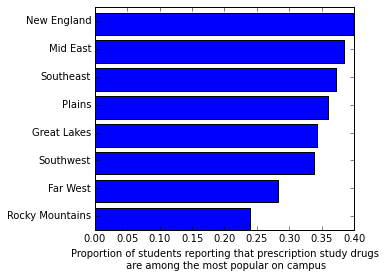

In [9]:
#Join Niche data with IPEDS data. 
niche_adderall_idxs = (niche_data['Response'] == 'Prescription "study drugs" (Adderall, Ritalin) ')
niche_adderall_fracs = niche_data.loc[niche_adderall_idxs]
at_least_ten_responses = niche_adderall_fracs['ResponseCt'] >= 10#filter out schools with very few responses. 
niche_adderall_fracs = niche_adderall_fracs.loc[at_least_ten_responses]
for school_characteristic in ipeds_data.keys():
    niche_adderall_fracs[school_characteristic] = niche_adderall_fracs['IPEDS_Id'].map(lambda x:ipeds_data[school_characteristic][x]
                                                                      if x in ipeds_data[school_characteristic]
                                                                      else None)
    
#Make geographic plot and run regression to confirm discrepancies are significant. 
region_vals = []
region_names = []
for region in list(set(ipeds_data['HD2013_Geographic_region'].values())):
    region_idxs = niche_adderall_fracs['HD2013_Geographic_region'] == region
    if region_idxs.sum() >= 10:
        mean_val = niche_adderall_fracs.loc[region_idxs]['PctOfTotal'].mean()
        if np.isnan(mean_val):
            continue

        region_vals.append(mean_val)
        region_names.append(' '.join([a for a in region.split() if len(a) > 2]))
model = sm.OLS.from_formula('PctOfTotal ~ HD2013_Geographic_region', data = niche_adderall_fracs).fit()
print model.summary()
region_vals = np.array(region_vals)
region_names = np.array(region_names)
sorted_idxs = np.argsort(region_vals)
barh(range(len(region_vals)), region_vals[sorted_idxs])
yticks(np.arange(len(region_vals)) + .5, region_names[sorted_idxs])
subplots_adjust(left = .3)
xlabel('Proportion of students reporting that prescription study drugs\n are among the most popular on campus')

        

In [10]:
#Create data for chart (this chart did not end up being included).
print 'Region\tProportion'
for i in range(len(region_names)):
    print '%s\t%2.1f' % (region_names[sorted_idxs[::-1][i]], region_vals[sorted_idxs[::-1][i]] * 100)


Region	Proportion
New England	39.8
Mid East	38.5
Southeast	37.2
Plains	36.0
Great Lakes	34.3
Southwest	33.8
Far West	28.2
Rocky Mountains	23.9


###### "Study drugs were also more frequently used at colleges that were more selective or had higher median SAT or ACT scores. In the graph below, each point represents one school; the horizontal axis is the school’s 75th percentile ACT score, and the vertical axis is the fraction of students responding that study drugs are popular. The correlation is highly statistically significant"


Regressing percentage of students at each college saying study drugs are popular on various measures of college selectivity. 
For each measure of selectivity (first column) we run two regressions: 
a simple model -- study_drugs_popular ~ selectivity_measure
a more complex model -- study_drugs_popular ~ selectivity_measure + college_covs
where college_covs are college_racial_breakdown, college_gender_breakdown, college_type, and college_estimated_enrollment

below the columns are selectivity_measure, simple_selectivity_measure_beta, simple_selectivity_measure_p, complex_selectivity_measure_beta, complex_selectivity_measure_p

IC2013_SAT_Critical_Reading_75th_percentile_score            0.00068 1.352e-13 0.00057 9.374e-07
IC2013_SAT_Writing_75th_percentile_score                     0.00059 3.890e-10 0.00062 2.139e-06
IC2013_SAT_Math_75th_percentile_score                        0.00062 1.922e-13 0.00074 4.848e-10
IC2013_ACT_Composite_75th_percentile_score                   0.01531 5.626e

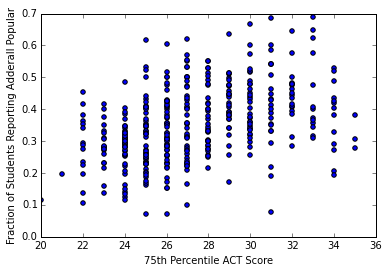

In [11]:
achievement_columns = ['IC2013_SAT_Critical_Reading_75th_percentile_score', 'IC2013_SAT_Writing_75th_percentile_score', 
                       'IC2013_SAT_Math_75th_percentile_score', 'IC2013_ACT_Composite_75th_percentile_score', 'DRVIC2013_Percent_admitted_total']
control_columns = ['DRVEF2013_White', 'DRVEF2013_women', 'IC2013_Institutional_control_or_affiliation', 
                   'DRVEF2013_Asian', 'DRVEF2013_American_Indian_or_Alaska_Native', 
                   'DRVEF2013_Black_or_African_American', 'EFEST2013_Estimated_enrollment__total', 
                   'DRVEF2013_Hispanic_Latino', 'DRVEF2013_Native_Hawaiian_or_Other_Pacific_Islander']
print """
Regressing percentage of students at each college saying study drugs are popular on various measures of college selectivity. 
For each measure of selectivity (first column) we run two regressions: 
a simple model -- study_drugs_popular ~ selectivity_measure
a more complex model -- study_drugs_popular ~ selectivity_measure + college_covs
where college_covs are college_racial_breakdown, college_gender_breakdown, college_type, and college_estimated_enrollment

below the columns are selectivity_measure, simple_selectivity_measure_beta, simple_selectivity_measure_p, complex_selectivity_measure_beta, complex_selectivity_measure_p
"""

for coef in achievement_columns:
    model = sm.OLS.from_formula('PctOfTotal ~ %s' % coef, data = niche_adderall_fracs).fit()
    model_controlling_for_covariates = sm.OLS.from_formula('PctOfTotal ~ %s + %s' % (coef, '+'.join(control_columns)), data = niche_adderall_fracs).fit()
    print '%-60s %3.5f %2.3e %3.5f %2.3e' % (coef, model.params[coef], model.pvalues[coef], 
                                 model_controlling_for_covariates.params[coef], model_controlling_for_covariates.pvalues[coef])
scatter(niche_adderall_fracs['IC2013_ACT_Composite_75th_percentile_score'], niche_adderall_fracs['PctOfTotal'])
xlabel('75th Percentile ACT Score')
ylabel('Fraction of Students Reporting Adderall Popular')
xlim([20, 36])
ylim([0, .7])

show()
                   
                       

In [14]:
#Print out data for chart. 
model = sm.OLS.from_formula('PctOfTotal ~ IC2013_ACT_Composite_75th_percentile_score', data = niche_adderall_fracs).fit()
ones_to_plot = niche_adderall_fracs[['IC2013_ACT_Composite_75th_percentile_score', 'PctOfTotal']].dropna()
ones_to_plot['trendline'] = niche_adderall_fracs['IC2013_ACT_Composite_75th_percentile_score'] * model.params['IC2013_ACT_Composite_75th_percentile_score'] + model.params['Intercept']
ones_to_plot['trendline'] = ones_to_plot['trendline'] * 100
print 'ACT\tAdderall\tTrendline'
for i in range(len(ones_to_plot)):
    print '%2.3f\t%2.3f\t%2.3f' % (ones_to_plot['IC2013_ACT_Composite_75th_percentile_score'].iloc[i],
                                   ones_to_plot['PctOfTotal'].iloc[i] * 100, 
                                   ones_to_plot['trendline'].iloc[i])

ACT	Adderall	Trendline
27.000	31.480	35.021
29.000	42.110	38.082
30.000	47.960	39.613
23.000	23.260	28.898
28.000	36.960	36.552
28.000	33.910	36.552
23.000	27.120	28.898
30.000	60.000	39.613
27.000	53.130	35.021
24.000	30.890	30.429
29.000	34.040	38.082
29.000	28.330	38.082
30.000	45.160	39.613
30.000	43.750	39.613
23.000	28.260	28.898
26.000	29.070	33.490
33.000	64.710	44.205
30.000	48.760	39.613
33.000	68.970	44.205
24.000	31.330	30.429
28.000	51.350	36.552
32.000	28.570	42.674
31.000	7.720	41.144
25.000	7.180	31.959
34.000	29.170	45.736
27.000	62.160	35.021
32.000	50.000	42.674
30.000	34.690	39.613
26.000	40.000	33.490
30.000	43.180	39.613
26.000	15.180	33.490
24.000	29.070	30.429
22.000	10.680	27.367
24.000	12.350	30.429
24.000	22.360	30.429
22.000	19.650	27.367
22.000	13.890	27.367
20.000	11.460	24.306
23.000	28.000	28.898
34.000	41.940	45.736
26.000	23.260	33.490
27.000	35.560	35.021
33.000	37.140	44.205
27.000	40.540	35.021
25.000	21.150	31.959
24.000	34.650	30.429
23.000	26.090

###### "When I looked at the NSDUH data, I found that college students who had used Adderall non-medically reported significantly higher levels of depression and were more likely to have considered suicide."

In [15]:
def lookAtDepressionLevels(nsduh_data, idxs):
    nsduh_data['seriously_thought_about_killing_oneself_last_year'] = 1.* (nsduh_data['MHSUITHK'] == 1)
    nsduh_data['worst_K6_score_past_year'] = 1.*nsduh_data['K6SCMAX']
    data_to_use = nsduh_data.loc[idxs]
    weights = data_to_use['ANALWT_C']
    stratifyByCat(data_to_use, 'seriously_thought_about_killing_oneself_last_year')  

    model1 = sm.Logit.from_formula('ADDERALL ~ seriously_thought_about_killing_oneself_last_year', 
                                 weights = weights, 
                                 data = data_to_use).fit()
    model2 = sm.Logit.from_formula('ADDERALL ~ seriously_thought_about_killing_oneself_last_year +  IRSEX + C(IRFSTAMP, Sum) + C(NEWRACE2, Sum)', 
                                 weights = weights, 
                                 data = data_to_use).fit()
    model3 = sm.Logit.from_formula('ADDERALL ~ worst_K6_score_past_year', 
                                 weights = weights, 
                                 data = data_to_use).fit()
    model4 = sm.Logit.from_formula('ADDERALL ~ worst_K6_score_past_year + IRSEX + C(IRFSTAMP, Sum) + C(NEWRACE2, Sum)', 
                                 weights = weights, 
                                 data = data_to_use).fit()


    models = [model1, model2, model3, model4]
    print summary_col(models, model_names = range(len(models)), stars = True,
                      regressor_order = ['seriously_thought_about_killing_oneself_last_year', 'worst_K6_score_past_year'],
                      float_format='%0.3f',
                      info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})
college_idxs = nsduh_data['COLLENR'] == 1
adult_idxs = nsduh_data['CATAG6'] >= 3

print '\n\nLooking at depression levels in college students'
lookAtDepressionLevels(nsduh_data, college_idxs)
print '\n\nLooking at depression levels in adults'
lookAtDepressionLevels(nsduh_data, adult_idxs)



Looking at depression levels in college students
Category seriously_thought_about_killing_oneself_last_year
Mean value of ADDERALL for level 0.0 is 0.143; unweighted, 0.136 (3944 values)
Mean value of ADDERALL for level 1.0 is 0.213; unweighted, 0.191 (366 values)
Ratio between maximum value and minimum value 1.48723023239
Optimization terminated successfully.
         Current function value: 0.404718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386725
         Iterations 7

                                                      0         1         2         3    
-----------------------------------------------------------------------------------------
seriously_thought_about_killing_oneself_last_year 0.410***  0.435***                

###### "I found that Google searches for Adderall in college towns spiked during exam months and drop during summer months."

0 towns processed out of 2084
Hamilton, New York not in index
Farmville, Virginia not in index
10 towns processed out of 2084
Canton, New York not in index
Orono, Maine not in index
20 towns processed out of 2084
Menomonie, Wisconsin not in index
Lexington, Virginia not in index
30 towns processed out of 2084
40 towns processed out of 2084
Geneseo, New York not in index
Kutztown, Pennsylvania not in index
50 towns processed out of 2084
60 towns processed out of 2084
Frostburg, Maryland not in index
70 towns processed out of 2084
town 4355
ADHD 4355
ADHD_zero_meaned_by_town 4355
month 4355
ADHD_normalized_by_town 4355
year 4355
Adderall 4355
Adderall_normalized_by_town 4355
Adderall_zero_meaned_by_town 4355


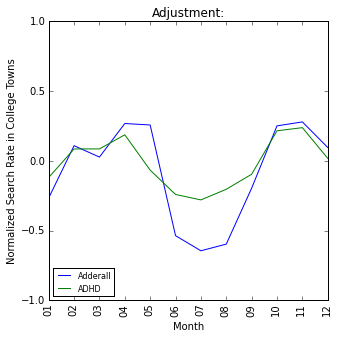

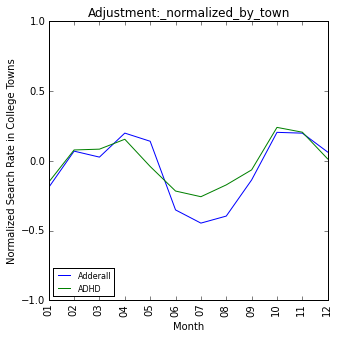

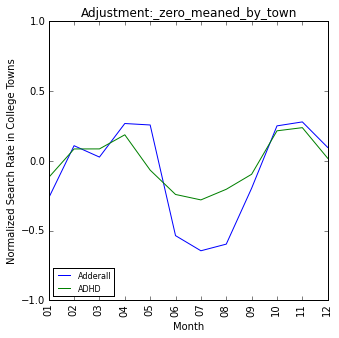

In [16]:
college_towns_to_percentages = {}
#read in college towns. 
for line in open('college_town_percentages'):
    line = ' '.join(line.split()[1:])
    city_name = line.split('(')[0].strip()
    percentage = float(line.split('(')[1].replace('%)', ''))
    if city_name in d.index:
        college_towns_to_percentages[city_name] = percentage
#reprocess google data into easier-to-analyze format. 
def createGoogleSearchDataframe(all_searches, college_towns_to_percentages):
    df = {'month':[], 'year':[], 'town':[]}
    for k in all_searches:
        df[k] = []
        df[k + '_normalized_by_town'] = []
        df[k + '_zero_meaned_by_town'] = []
    
    for i, town_name in enumerate(college_towns_to_percentages.keys()):
        if i % 10 == 0:
            print i,'towns processed out of', len(d.index)
        
        mean_vals_by_town = {}
        bad_town = False
        for k in all_searches:
            mean_vals_by_town[k] = {}
            if town_name not in all_searches[k].index:
                print town_name, 'not in index'
                bad_town = True
            if town_name in all_searches[k].index:
                mean_vals_by_town[k]['mu'] = all_searches[k].loc[town_name].mean()
                mean_vals_by_town[k]['sigma'] = all_searches[k].loc[town_name].std()
        if bad_town:
            continue
        for date in all_searches['Adderall'].columns:
            month = date.split('-')[1]
            year = date.split('-')[0]
            df['month'].append(month)
            df['year'].append(year)
            df['town'].append(town_name)
            for k in all_searches.keys():
                search_volume = float(all_searches[k].loc[town_name][date])
                df[k].append(search_volume)
                df[k + '_normalized_by_town'].append((search_volume - mean_vals_by_town[k]['mu']) / mean_vals_by_town[k]['sigma'])
                df[k + '_zero_meaned_by_town'].append((search_volume - mean_vals_by_town[k]['mu']))

    for a in df.keys():
        print a, len(df[a])
    df = pd.DataFrame(df)
    return df
google_search_dataframe = createGoogleSearchDataframe(google_data, college_towns_to_percentages)

#Do regressions for various adjustments to the Google data to confirm we see the same pattern. 
#Eg, if we subtract off the mean for each town, do we still see it? What if we divide by each town's standard deviation...? Pattern is robust to all these things. 
for adjustment_to_use in ['', '_normalized_by_town', '_zero_meaned_by_town']:
    figure(figsize = [5, 5])
    for k in ['Adderall', 'ADHD']:
        model = sm.OLS.from_formula('%s ~ C(month, Sum) + C(year, Sum)' 
                                    % (k + adjustment_to_use), data = google_search_dataframe).fit()
        month_coefs = []
        month_ticks = []
        for param in model.params.index:
            if 'month' in param:
                month_coefs.append(model.params[param])
                month_ticks.append(param.split('S.')[1].replace(']', ''))
        month_coefs.append(- np.mean(month_coefs))
        month_ticks.append('12')
        plot(range(len(month_coefs)), month_coefs, label = k)
        xticks(range(len(month_coefs)), month_ticks, rotation = 90)
    ylim([-1, 1])
    legend(loc = 3, fontsize = 8)

    xlabel('Month')
    ylabel('Normalized Search Rate in College Towns')
    title('Adjustment:' +adjustment_to_use)


###### "In fact, NSDUH data showed that adults whose family incomes were below 10,000 had the highest rates of nonmedical Adderall use, and those whose family incomes were greater than 75,000 had the lowest."

In [17]:
#run regressions + stratify by income levels to confirm that we observe income effects.
adult_idxs = nsduh_data['CATAG6'] >= 3

data_to_use = nsduh_data.loc[adult_idxs]
weights = data_to_use['ANALWT_C']
print 'Examining Adderall use frequency in adults as a function of family income'
print 'Ritalin results are qualitatively similar although the effects seem to be weaker'
print '\nCategories for total family income:\n1: <10k, 2: 10-20, 3: 20-30; 4: 30-40; 5: 40-50; 6: 50-75; 7: 75'
stratifyByCat(data_to_use, 'IRFAMIN3')  
stratifyByCat(data_to_use, 'IRFAMIN3', drug_to_measure = 'RITALIN')


model1 = sm.Logit.from_formula('ADDERALL ~ C(IRFAMIN3)', data = data_to_use, weights = weights).fit()#treat income as categorical variable
model2 = sm.Logit.from_formula('ADDERALL ~ IRFAMIN3', data = data_to_use, weights = weights).fit()#treat as continuous variable (bad, bad, bad)
model3 = sm.Logit.from_formula('ADDERALL ~ IRSEX + C(CATAG6, Sum) + C(NEWRACE2, Sum) + C(IRFAMIN3)', data = data_to_use, weights = weights).fit()#control for other covariates: age, race, sex. 
model4 = sm.Logit.from_formula('RITALIN ~ C(IRFAMIN3)', data = data_to_use, weights = weights).fit()
model5 = sm.Logit.from_formula('RITALIN ~ IRFAMIN3', data = data_to_use, weights = weights).fit()
model6 = sm.Logit.from_formula('RITALIN ~ IRSEX + C(CATAG6, Sum) + C(NEWRACE2, Sum) + C(IRFAMIN3)', data = data_to_use, weights = weights).fit()

models = [model1, model2, model3, model4, model5, model6]
print summary_col(models, model_names = ['ADDERALL', 'ADDERALL', 'ADDERALL', 'RITALIN', 'RITALIN', 'RITALIN'], stars = True,
                  float_format='%0.3f',
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

Examining Adderall use frequency in adults as a function of family income
Ritalin results are qualitatively similar although the effects seem to be weaker

Categories for total family income:
1: <10k, 2: 10-20, 3: 20-30; 4: 30-40; 5: 40-50; 6: 50-75; 7: 75
Category IRFAMIN3
Mean value of ADDERALL for level 1 is 0.037; unweighted, 0.053 (1132 values)
Mean value of ADDERALL for level 2 is 0.025; unweighted, 0.036 (2308 values)
Mean value of ADDERALL for level 3 is 0.032; unweighted, 0.042 (2102 values)
Mean value of ADDERALL for level 4 is 0.032; unweighted, 0.040 (2100 values)
Mean value of ADDERALL for level 5 is 0.029; unweighted, 0.036 (2085 values)
Mean value of ADDERALL for level 6 is 0.028; unweighted, 0.033 (3418 values)
Mean value of ADDERALL for level 7 is 0.024; unweighted, 0.031 (6137 values)
Ratio between maximum value and minimum value 1.52577800068
Category IRFAMIN3
Mean value of RITALIN for level 1 is 0.030; unweighted, 0.038 (1132 values)
Mean value of RITALIN for level 